In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import UnivariateSpline, CubicSpline

In [2]:
from data_processing.align_segmented_road_with_lidar import get_aerial_lidar_road_geo_df, get_mapping_data, init_transform_from_lidar_to_world_coordinate_system
from data_processing.extract_lidar_3d_points import extract_lidar_3d_points_for_camera
from data_processing.utils import compute_match, create_gdf_from_df, bearing_between_two_latlon_points, add_lidar_x_y_from_lat_lon

PERSPECTIVE_NEAR, PERSPECTIVE_VFOV, CAMERA_LIDAR_X_OFFSET, CAMERA_LIDAR_Y_OFFSET, CAMERA_LIDAR_Z_OFFSET, \
    CAMERA_YAW, CAMERA_PITCH, CAMERA_ROLL = 0, 1, 2, 3, 4, 5, 6, 7
INIT_CAMERA_PARAMS = [0.1, 20, 5.4, -7.1, 14, -0.049, 1.7, -0.18]
LIDAR_DIST_THRESHOLD = (0, 124)
SPLINE_FIT_DIST_THRESHOLD = 15
SPLINE_SMOOTHING_FACTOR = 100
PREV_CAM_PARAS = None
PREV_CAM_BEARING_VEC = None

input_lidar = 'data/new_test_scene/new_test_scene_road_bounds.csv'
ldf = get_aerial_lidar_road_geo_df(input_lidar)
input_mapping_file = 'data/d13_route_40001001011/other/mapped_2lane_sr_images_d13.csv'
input_2d_mapped_images = ['88100095421', '88100095501', '88100095513']
vecs_cubic = []
vecs_smooth = []
cams = []
splines_xy_cubic = []
splines_xz_cubic = []
splines_xy_smooth = []
splines_xz_smooth = []
sorted_ldfs = []
unique_xs = []
for i, img in enumerate(input_2d_mapped_images):
    cam_lat, cam_lon, proj_cam_x, proj_cam_y, cam_br, cam_lat2, cam_lon2, eor = \
            get_mapping_data(input_mapping_file, img)
    cam_nearest_lidar_idx = compute_match(proj_cam_x, proj_cam_y, ldf['X'], ldf['Y'])[0][0]
    cam_lidar_z = ldf.iloc[cam_nearest_lidar_idx].Z
    vertices, cam_br, cols = extract_lidar_3d_points_for_camera(ldf, [cam_lat, cam_lon], [cam_lat2, cam_lon2],
                                                                    dist_th=LIDAR_DIST_THRESHOLD,
                                                                    end_of_route=eor)
    input_3d_points = vertices[0]
    input_3d_df = pd.DataFrame(data=input_3d_points, columns=cols)
    if 'BOUND' in cols:
        input_3d_df['BOUND'] = input_3d_df['BOUND'].astype(int)
    input_3d_df['X'] = input_3d_df['X'].astype(float)
    input_3d_df['Y'] = input_3d_df['Y'].astype(float)
    input_3d_df['Z'] = input_3d_df['Z'].astype(float)
    if 'C' in cols:
        input_3d_df['C'] = input_3d_df['C'].astype(int)
    input_3d_gdf = create_gdf_from_df(input_3d_df)  
    input_3d_gdf['BEARING'] = input_3d_gdf['geometry_y'].apply(lambda geom: bearing_between_two_latlon_points(
            cam_lat, cam_lon, geom.y, geom.x, is_degree=False) - cam_br)
    input_3d_gdf = init_transform_from_lidar_to_world_coordinate_system(input_3d_gdf, proj_cam_x, proj_cam_y,
                                                                            cam_lidar_z)
    cam_df = pd.DataFrame(data={'LATITUDE': [cam_lat2], 'LONGITUDE': [cam_lon2]})
    cam_gdf = add_lidar_x_y_from_lat_lon(cam_df)
    proj_cam_x2 = cam_gdf.iloc[0].x
    proj_cam_y2 = cam_gdf.iloc[0].y
    cam2_nearest_lidar_idx = compute_match(proj_cam_x2, proj_cam_y2, ldf['X'], ldf['Y'])[0][0]
    proj_cam_z2 = ldf.iloc[cam2_nearest_lidar_idx].Z
    v = np.array([proj_cam_x2 - proj_cam_x, proj_cam_y2 - proj_cam_y, proj_cam_z2 - cam_lidar_z])
    v = v / np.linalg.norm(v)
    cams.append(v)
    filtered_road_ldf = input_3d_gdf[input_3d_gdf.CAM_DIST < SPLINE_FIT_DIST_THRESHOLD]
    sorted_ldf = filtered_road_ldf.sort_values(by=['CAM_DIST'])
    sorted_ldfs.append(sorted_ldf[["X", "Y", "Z", "CAM_DIST"]])
    x = sorted_ldf['X'].values
    y = sorted_ldf['Y'].values
    z = sorted_ldf['Z'].values
    unique_x, unique_indices = np.unique(x, return_index=True)
    unique_xs.append(unique_x)
    unique_y = y[unique_indices]
    unique_z = z[unique_indices]
    spline_xy = CubicSpline(unique_x, unique_y)
    spline_xz = CubicSpline(unique_x, unique_z)
    splines_xy_cubic.append(spline_xy)
    splines_xz_cubic.append(spline_xz)    
    cam_tan_x = spline_xy.derivative()(sorted_ldf['X'].iloc[0])
    cam_tan_y = spline_xy.derivative()(sorted_ldf['Y'].iloc[0])
    cam_tan_z = spline_xz.derivative()(sorted_ldf['Z'].iloc[0])
    print(cam_tan_x, cam_tan_y, cam_tan_z)
    v = np.array([cam_tan_x, cam_tan_y, cam_tan_z])
    v = v / np.linalg.norm(v)
    vecs_cubic.append(v)
    spline_xy = UnivariateSpline(unique_x, unique_y, s=SPLINE_SMOOTHING_FACTOR)
    spline_xz = UnivariateSpline(unique_x, unique_z, s=SPLINE_SMOOTHING_FACTOR)
    splines_xy_smooth.append(spline_xy)
    splines_xz_smooth.append(spline_xz)
    cam_tan_x = spline_xy.derivative()(sorted_ldf['X'].iloc[0])
    cam_tan_y = spline_xy.derivative()(sorted_ldf['Y'].iloc[0])
    cam_tan_z = spline_xz.derivative()(sorted_ldf['Z'].iloc[0])
    print(cam_tan_x, cam_tan_y, cam_tan_z)
    v = np.array([cam_tan_x, cam_tan_y, cam_tan_z])
    v = v / np.linalg.norm(v)
    vecs_smooth.append(v)

print(f'cams: {cams}')
print(f'vecs_cubic: {vecs_cubic}')
print(f'vecs_smooth: {vecs_smooth}')

cam lat-long: 35.68439--81.5219035, proj cam y-x: 713527.8801927171-1251184.1450072322, cam_br: 3.330153836163958
-36.50643579606229 -4158515184550042.0 326816215761036.3
2.185840575960394 -230909596645.48257 20513888495.975353
cam lat-long: 35.6843236--81.5219191, proj cam y-x: 713503.8372082941-1251178.9000517835, cam_br: 3.3254405816185435
-353.79842649541774 -2173054757397696.0 -264469959915663.8
2.4064939689991798 -457619963067.0972 36466491069.06969
cam lat-long: 35.6842441--81.5219373, proj cam y-x: 713475.0472020688-1251172.7621275173, cam_br: 3.3328953528079595
22.675302939481643 -3173683982686.083 -5851685929471.052
0.9413336044468906 13199190.331896305 7311006323.522581
cams: [array([-0.21313593, -0.97701951, -0.00243818]), array([-0.20850887, -0.97801334, -0.00373676]), array([-0.21582036, -0.97640789,  0.0070147 ])]
vecs_cubic: [array([-8.75173369e-15, -9.96926066e-01,  7.83480617e-02]), array([-1.61619012e-13, -9.92675310e-01, -1.20812786e-01]), array([ 3.40627871e-12, -4

[array([-0.21313593, -0.97701951, -0.00243818]), array([-0.20850887, -0.97801334, -0.00373676]), array([-0.21582036, -0.97640789,  0.0070147 ])]
-0.21313592913058074 -0.9770195141256808 -0.002438181958461206
-0.20850887431171983 -0.9780133362720302 -0.0037367642836959956
-0.21582035537844663 -0.9764078902720161 0.007014700198268613


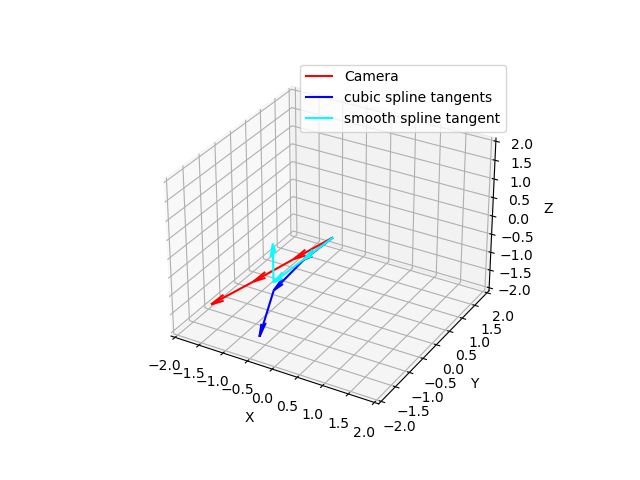

In [4]:
plt.clf()
# Plot vectors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot original camera vectors
ax.quiver(0, 0, 0, cams[0][0], cams[0][1], cams[0][2], color='r', label='Camera', normalize=True)
ax.quiver(cams[0][0], cams[0][1], cams[0][2], cams[1][0], cams[1][1], cams[1][2], color='r', normalize=True)
ax.quiver(cams[1][0]+cams[0][0], cams[1][1]+cams[0][1], cams[1][2]+cams[0][2], cams[2][0], cams[2][1], cams[2][2], color='r', normalize=True)
print(cams)
print(cams[0][0], cams[0][1], cams[0][2])
print(cams[1][0], cams[1][1], cams[1][2])
print(cams[2][0], cams[2][1], cams[2][2])
# Plot road tangent vectors
ax.quiver(0, 0, 0, vecs_cubic[0][0], vecs_cubic[0][1], vecs_cubic[0][2], color='b', label='cubic spline tangents', normalize=True)
ax.quiver(vecs_cubic[0][0], vecs_cubic[0][1], vecs_cubic[0][2], vecs_cubic[1][0], vecs_cubic[1][1], vecs_cubic[1][2], color='b', normalize=True)
ax.quiver(vecs_cubic[1][0]+vecs_cubic[0][0], vecs_cubic[1][1]+vecs_cubic[0][1], vecs_cubic[1][2]+vecs_cubic[0][2], vecs_cubic[2][0], vecs_cubic[2][1], vecs_cubic[2][2], color='b', normalize=True)
ax.quiver(0, 0, 0, vecs_smooth[0][0], vecs_smooth[0][1], vecs_smooth[0][2], color='cyan', label='smooth spline tangent', normalize=True)
ax.quiver(vecs_smooth[0][0], vecs_smooth[0][1], vecs_smooth[0][2], vecs_smooth[1][0], vecs_smooth[1][1], vecs_smooth[1][2], color='cyan', normalize=True)
ax.quiver(vecs_smooth[1][0]+vecs_smooth[0][0], vecs_smooth[1][1]+vecs_smooth[0][1], vecs_smooth[1][2]+vecs_smooth[0][2], vecs_smooth[2][0], vecs_smooth[2][1], vecs_smooth[2][2], color='cyan', normalize=True)

ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

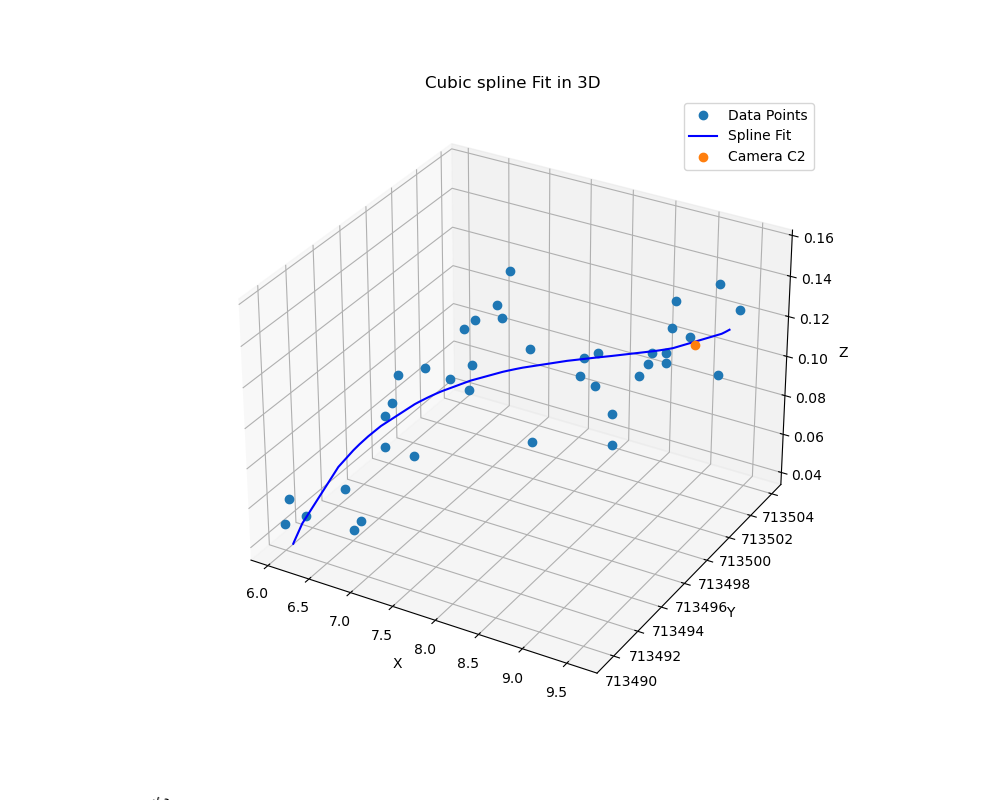

In [14]:
plt.clf()
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

cam_locs = [
    [1251184.145, 713527.88, 1185.16],
    [1251178.9, 713503.84, 1185.1],
    [1251172.76, 713475.05, 1184.99]
]

# Define points at which you want to visualize the splines
i = 1
points = np.array(unique_xs[i])

# Evaluate the splines at the specified points
points_y = splines_xy_smooth[i](points)
points_z = splines_xz_smooth[i](points)

# Plot the cubic splines in 3D

# Plot the x-y-z spline
ax.plot(sorted_ldfs[i]['X'], sorted_ldfs[i]['Y'], sorted_ldfs[i]['Z'], 'o', label='Data Points')
ax.plot(points, points_y, points_z, label='Spline Fit', color='blue')
ax.plot(cam_locs[i][0], cam_locs[i][1], cam_locs[i][2], 'o', label='Camera C2')
# ax.plot(cam_locs[i+1][0], cam_locs[i+1][1], cam_locs[i+1][2], 'o', label='Camera C3')
# ax.quiver(-0.8974274843143826, 0.0, -0.8198294518294904, v[0]*10, v[1]*10, v[2]*10, color='r', label='camera tangent')
# ax.set_xlim([-1.5, 0])
# ax.set_ylim([-0.1, 0.1])
# ax.set_zlim([-15, 0])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Cubic spline Fit in 3D')

ax.legend()
plt.show()